# emcee: PHYS265 Final Project

In this project, we introduce the emcee package, and in particular its usage in fitting a model to data when you don't trust uncertainties/the data is noisy. First, let's generate some noisy data for a linear fit with prescribed parameters:

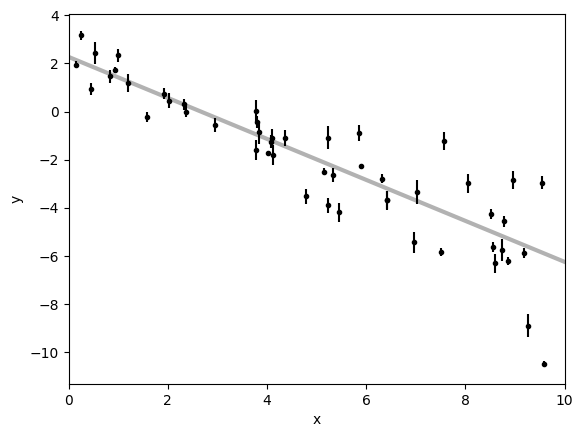

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(256)

# Choose the "true" parameters.
m_true = -0.8520
b_true = 2.275
f_true = 0.421

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.4 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

As can be seen from the plot, the errorbars are quite small compared to the spread of the data. This indicates that the error has been underestimated. Let's see what happens when we try to use least-squares to fit the model to data:

Least-squares estimates:
m = -1.011 ± 0.010
b = 2.675 ± 0.060


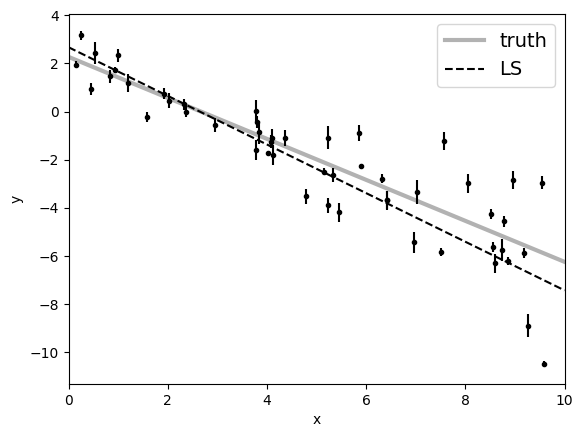

In [2]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Clearly, the least-squares method doesn't give the best fit to the data, especially at the tail end of the distribution. We can fix this by using maximum likelihood estimation. The least-squares method assumes that our errors are correct, independent, and Gaussian (which we know is not true). Hence, what we need to do to fix this is numerically optimize the likelihood function (equivalent to optimizing the log of the likelihood function).

In [3]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.884
b = 2.266
f = 0.404


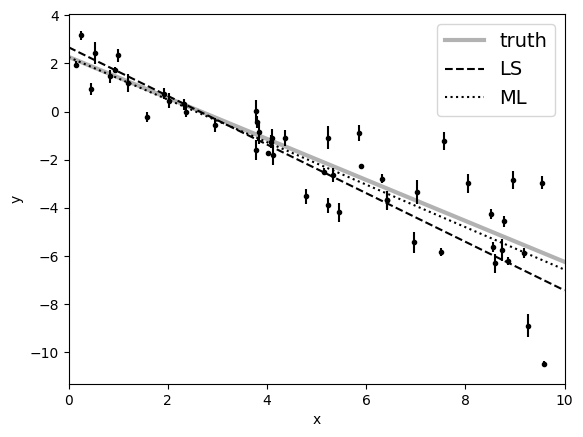

In [4]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This indeed gives us a better result; however, it doesn't give information on how to propagate uncertainties on the parameters of the model (m,b, and f). For that, we need to use emcee, since it generates a posterior distribution of parameter probabilities (which allows us to estimate uncertainties through covariances). We first need a prior distribution of parameters, encompassing all information we have (from experiment, other analysis, etc).

In [5]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

This then factors into our probability distribution as follows:

In [6]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Now we just need to generate the walkers to explore the probability distribution. They'll start out distributed in a small Gaussian ball outside of the maximum likelihood.

In [7]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000);

The following plot just shows how the walkers explore the distribution, with the x-axis indicating the number of steps. Notice how they start out at the maximum value, but quickly start exploring a large part of the distribution around this maximum value.

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The time taken for the walkers to "forget" where they were initialized is called the autocorrelation time; it is related to how many steps the walkers take to "burn-in" and go from the small Gaussian ball to a larger range around the distribution. This is important, since we don't want to bias samples from around the start location.

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

Now that we've determined our autocorrelation time (about 40 steps), we can generate our samples. We'll cut the first 100 samples to ensure our walkers are fully burned in once we start sampling, thin by 15 samples (half the autocorrelation time) to again ensure that our samples are distributed uniformly, and flatten out the chain of samples.

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


It is now time for us to visualize our output posterior probability distributions. We can do this by making a corner plot of the samples, giving us 2d and 1d projections of the probability distribution:

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);
plt.savefig("Figure2.png")

Finally, we can plot our samples against our data (and the true model) to see how they line up.

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");
plt.savefig("Figure1.png")

Finally, we can quote our fit parameters and uncertainties by looking at the 16th, 50th, and 84th percentiles of the sample data for each parameter (meaning the 50th percentile is the data value, and the difference between it and the 16th and 84th percentiles determine the two uncertainties).

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))